# How this notebook is structured<br>
I want to create a predictive model based on the data on defaulted loans that I have obtained from kaggle.com. To do  so, I will take the following steps:
1. Data Pre-processing<br>
    a). Cleaning the data <br>
    b). Handling missing values<br>
    c). Balancing the data with respect to the dependent variable<br><br>
2. Feature Selection <br>
    a). Checking correlations between the predictors and the dependent variable<br>
    b). Examining interdependencies between predictors (to avoid noise and overfitting)<br>
    c). Choosing final features for the models<br>
    d). Preparing variables for models (e.g. categorical variables -> numerical variables)<br><br>
3. Training multiple models<br>
    a). Logistic Regression<br>
    b). Random Forest<br>
    c). XGBoost<br>
    d). Support Vector Machine<br><br>
4. Choosing the best performing model based on ROC and P-R AUCs<br><br>
5. Hyperparameter tuning of the chosen model<br><br>
6. Conclusions and recommendations 

In [1]:
#importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
import statsmodels.api as statsmodels
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv("loan.csv", low_memory=False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [5]:
list(df)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [6]:
#Creating a column that contains the names of the columns with missing values and their respective number of missing values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

id                                            2260668
member_id                                     2260668
emp_title                                      166969
emp_length                                     146907
annual_inc                                          4
url                                           2260668
desc                                          2134601
title                                           23325
zip_code                                            1
dti                                              1711
delinq_2yrs                                        29
earliest_cr_line                                   29
inq_last_6mths                                     30
mths_since_last_delinq                        1158502
mths_since_last_record                        1901512
open_acc                                           29
pub_rec                                            29
revol_util                                       1802
total_acc                   

In [7]:
#I will drop the columns that have more than 50% of values missing
df.dropna(axis=1,thresh=(2260668-1130334), inplace=True)
df.shape

(2260668, 101)

I have dropped 44 columns. I will also drop all the entries were any of the data is missing. Given the huge size of the data, I will still be left with multiple entries to work with. In the best case scenario, I would examine both the columns with multiple null values and the entries with missing data because they might contain some important information (maybe a lack of some specific information could be a good predictor of the customer running on default). However, given the time constraints I will stick with only the data that is present in the set

In [8]:
#Marking all the good loans as 'Satisfactory' and all the defaulted ones as 'Default'. The segregation based on the guidelines of the task
df.replace(to_replace=['Charged Off','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off', 'Default'], value='Default', inplace=True)
df.replace(to_replace=['Fully Paid', 'Current', 'In Grace Period', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Fully Paid'], value='Satisfactory', inplace=True)
default_vs_good=df['loan_status'].value_counts()
print('Percent of defaulted loans:',(default_vs_good[1]/(default_vs_good[0]+default_vs_good[1]))*100,'%')

Percent of defaulted loans: 12.57787521210545 %


In [9]:
df = df.dropna(axis=0, how='any')
df.shape

(917472, 101)

In [10]:
df['loan_status'].unique()

array(['Satisfactory', 'Default'], dtype=object)

It might be the case that I will have a highly unbalanced data in the 'loan_status' column. I will check if that's true and if so, take required steps

In [11]:
df['loan_status'].value_counts()

Satisfactory    830511
Default          86961
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Figure: Distribution of loan statuses')

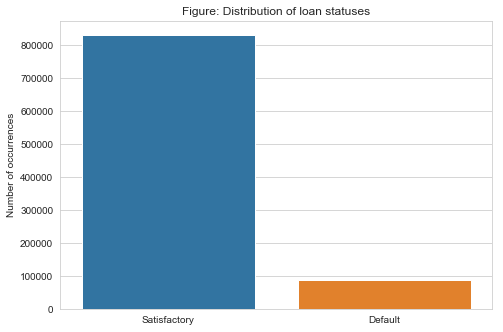

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax = sns.countplot(x="loan_status", data=df)
ax.set_xlabel('')
ax.set_ylabel('Number of occurrences')
ax.set_title("Figure: Distribution of loan statuses")

The initial dataset consisted of 2M+ entries and 145 columns. After cleaning the data, I obtained the set of 900.000+ entries and 101 columns. To narrow down the dataset even more to decrease the computational demand of the operations, I will use all the entries where the variable of interest, ‘loan_status’ has ‘Default’ value and a downsampled number of randomly chosen entries with ‘Satisfactory’ value. I will use random sampling with replacement. By having a balanced dataset, the algorithm can find it easier to identify the patterns of interest in the data. However, I will need to test the model on the dataset with exact same distribution as the original data. Thus, I will train/test split now, and then downsample only the training dataset.

In [13]:
test_df = df.iloc[int(len(df)*0.7):]
train_df = df.iloc[:int(0.7*len(df))]
print("Train set size: {}".format(len(train_df)))
print("Number of defaults on train set: {}".format(len(train_df[train_df['loan_status']=='Default'])))

print("Test set size: {}".format(len(test_df)))
print("Number of defaults on test set: {}".format(len(test_df[test_df['loan_status']=='Default'])))


Train set size: 642230
Number of defaults on train set: 60247
Test set size: 275242
Number of defaults on test set: 26714


In [14]:
#Creating a new dataframe called 'defaulted' that consists of only defaulted loans
pd.defaulted=train_df[train_df['loan_status']=='Default']
#Creating a dataframe that contains only 'Sattisfactory' loans. It will be used for sampling and added to the defaulted dataframe
pd.satisfactory=train_df[train_df['loan_status']=='Satisfactory']
pd.sample_satisfactory=pd.satisfactory.sample(n=80000, replace=True)
#Creating new dataframe 'sampledf' and adding two dataframes with different loan_status values
pd.sampledf=pd.defaulted.append(pd.sample_satisfactory, sort=True)
sampledf=pd.sampledf
#reshuffling
sampledf = sampledf.sample(frac=1.0)
#Confirming that I obtained what I wanted
sampledf['loan_status'].value_counts()

Satisfactory    80000
Default         60247
Name: loan_status, dtype: int64

In order to run the logistic regression, I will have to convert the categorical variables into numerical ones. Wherever I have a binary type (i.e two categories) of values in a column, I will use 0s and 1s. In cases I have more than 2 options, I will create new columns (dummy variables) with 1s indicating the presence of a specific characteristic and 0s as lack thereof. I will also drop these columns which either contain multiple distinct values (because creating multiple new columns might have a detrimental impact on the performance of the model - creating more overfitting than delivering relevant information. It is because each raw variable represented by a group of dummy variables will cause loss of one degree of freedom, i.e. causing interdependency between variables, which is detrimental to the model), or do not seem to provide any relevance to the model. In some cases, I will transform categorical data into numerical by simply converting them to numbers - it will happen in case of ordinal variables. For transforming categorical variables into numerical ones, I will use pd.get_dummies and LabelEncoder.

In [15]:
categorical=sampledf.select_dtypes('object')
list(categorical)

['addr_state',
 'application_type',
 'debt_settlement_flag',
 'disbursement_method',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'loan_status',
 'purpose',
 'pymnt_plan',
 'sub_grade',
 'term',
 'title',
 'verification_status',
 'zip_code']

In [16]:
for column in categorical:
    print(sampledf[column].value_counts())

CA    18610
TX    12491
NY    10745
FL    10325
IL     5545
NJ     5227
OH     4997
PA     4844
GA     4442
NC     3896
MI     3840
VA     3701
MD     3459
AZ     3375
MA     3295
IN     2644
WA     2539
MN     2539
CO     2426
MO     2376
TN     2282
CT     2176
NV     2057
WI     1948
AL     1759
LA     1646
SC     1536
KY     1460
OK     1425
OR     1377
AR     1185
KS     1083
MS      984
UT      882
NE      742
NM      727
NH      673
HI      629
RI      604
WV      439
DE      412
ME      403
ID      386
MT      370
AK      319
ND      316
SD      312
VT      286
WY      279
DC      234
Name: addr_state, dtype: int64
Individual    131338
Joint App       8909
Name: application_type, dtype: int64
N    132192
Y      8055
Name: debt_settlement_flag, dtype: int64
Cash         132890
DirectPay      7357
Name: disbursement_method, dtype: int64
Sep-2004    1210
Sep-2005    1157
Sep-2003    1105
Aug-2005    1093
Aug-2006    1047
Aug-2003    1045
Oct-2004    1036
Aug-2004    1031
Oct-2003 

In [17]:
#Creating a list with the names of columns I certainly want to delete
to_drop=['addr_state', 'earliest_cr_line', 'emp_title', 'issue_d', 'last_credit_pull_d', 'last_pymnt_d','purpose', 'sub_grade', 'title', 'zip_code']

#Deleting the columns from the df I am working on
sampledf = sampledf.drop(columns=to_drop)
categorical = categorical.drop(columns=to_drop)

#There were 3 categorical variables in the 'verification_status' column, of which 2 were looking the same, hence I will replace one of these
sampledf.replace(to_replace=['Verified'], value='Source Verified', inplace=True)

In [18]:
for column in categorical:
    print(sampledf[column].value_counts())

Individual    131338
Joint App       8909
Name: application_type, dtype: int64
N    132192
Y      8055
Name: debt_settlement_flag, dtype: int64
Cash         132890
DirectPay      7357
Name: disbursement_method, dtype: int64
10+ years    49276
2 years      14339
3 years      12774
< 1 year     11294
1 year       10403
4 years       9782
5 years       9355
6 years       6645
8 years       5964
7 years       5256
9 years       5159
Name: emp_length, dtype: int64
C    42861
B    36189
D    24269
A    20778
E    10885
F     4092
G     1173
Name: grade, dtype: int64
N    140017
Y       230
Name: hardship_flag, dtype: int64
MORTGAGE    66978
RENT        57646
OWN         15572
ANY            51
Name: home_ownership, dtype: int64
w    110918
f     29329
Name: initial_list_status, dtype: int64
Satisfactory    80000
Default         60247
Name: loan_status, dtype: int64
n    140046
y       201
Name: pymnt_plan, dtype: int64
 36 months    96238
 60 months    44009
Name: term, dtype: int64
Source V

In [19]:
#import labelencoder
from sklearn.preprocessing import LabelEncoder
#instantiate labelencoder object
le = LabelEncoder()
binary=['application_type', 'debt_settlement_flag', 'disbursement_method', 'hardship_flag', 'initial_list_status', 'pymnt_plan', 'term','verification_status']
sampledf[binary] = sampledf[binary].apply(lambda col: le.fit_transform(col))
for column in categorical:
    print(sampledf[column].value_counts())

0    131338
1      8909
Name: application_type, dtype: int64
0    132192
1      8055
Name: debt_settlement_flag, dtype: int64
0    132890
1      7357
Name: disbursement_method, dtype: int64
10+ years    49276
2 years      14339
3 years      12774
< 1 year     11294
1 year       10403
4 years       9782
5 years       9355
6 years       6645
8 years       5964
7 years       5256
9 years       5159
Name: emp_length, dtype: int64
C    42861
B    36189
D    24269
A    20778
E    10885
F     4092
G     1173
Name: grade, dtype: int64
0    140017
1       230
Name: hardship_flag, dtype: int64
MORTGAGE    66978
RENT        57646
OWN         15572
ANY            51
Name: home_ownership, dtype: int64
1    110918
0     29329
Name: initial_list_status, dtype: int64
Satisfactory    80000
Default         60247
Name: loan_status, dtype: int64
0    140046
1       201
Name: pymnt_plan, dtype: int64
0    96238
1    44009
Name: term, dtype: int64
1    98068
0    42179
Name: verification_status, dtype: int6

In [20]:
sampledf = pd.get_dummies(sampledf, columns=['home_ownership'])

In [21]:
sampledf.replace(to_replace={'emp_length':{'< 1 year':0.5, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, 
                                           '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10 years':10, '10+ years':15}, 
                            'grade':{'G':0,'F':1, 'E':2, 'D':3, 'C':4, 'B':5, 'A':6},
                            'loan_status':{'Default':1, 'Satisfactory':0}}, inplace=True)

In [22]:
#I have all the numerical variables, hence I can proceed further
sampledf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140247 entries, 708961 to 717404
Data columns (total 94 columns):
acc_now_delinq                140247 non-null float64
acc_open_past_24mths          140247 non-null float64
all_util                      140247 non-null float64
annual_inc                    140247 non-null float64
application_type              140247 non-null int64
avg_cur_bal                   140247 non-null float64
bc_open_to_buy                140247 non-null float64
bc_util                       140247 non-null float64
chargeoff_within_12_mths      140247 non-null float64
collection_recovery_fee       140247 non-null float64
collections_12_mths_ex_med    140247 non-null float64
debt_settlement_flag          140247 non-null int64
delinq_2yrs                   140247 non-null float64
delinq_amnt                   140247 non-null float64
disbursement_method           140247 non-null int64
dti                           140247 non-null float64
emp_length                

Repeating the same pre-processing steps for the test set so that the same structure is preserved

In [23]:
categorical_test=test_df.select_dtypes('object')
#Deleting the columns from the df I am working on
test_df = test_df.drop(columns=to_drop)
categorical_test = categorical_test.drop(columns=to_drop)

#There were 3 categorical variables in the 'verification_status' column, of which 2 were looking the same, hence I will replace one of these
test_df.replace(to_replace=['Verified'], value='Source Verified', inplace=True)

test_df[binary] = test_df[binary].apply(lambda col: le.fit_transform(col))
for column in categorical_test:
    print(test_df[column].value_counts())
    
test_df = pd.get_dummies(test_df, columns=['home_ownership'])

test_df.replace(to_replace={'emp_length':{'< 1 year':0.5, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, 
                                           '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10 years':10, '10+ years':15}, 
                            'grade':{'G':0,'F':1, 'E':2, 'D':3, 'C':4, 'B':5, 'A':6},
                            'loan_status':{'Default':1, 'Satisfactory':0}}, inplace=True)

0    195752
1     79490
Name: term, dtype: int64
C    91873
B    80108
A    47413
D    36270
E    12817
F     4156
G     2605
Name: grade, dtype: int64
10+ years    96072
< 1 year     29202
2 years      27500
3 years      23867
1 year       19563
4 years      18494
5 years      17834
6 years      13009
7 years      10913
9 years      10094
8 years       8694
Name: emp_length, dtype: int64
MORTGAGE    140331
RENT        105352
OWN          29289
ANY            270
Name: home_ownership, dtype: int64
1    176867
0     98375
Name: verification_status, dtype: int64
Satisfactory    248528
Default          26714
Name: loan_status, dtype: int64
0    275023
1       219
Name: pymnt_plan, dtype: int64
1    214458
0     60784
Name: initial_list_status, dtype: int64
0    248996
1     26246
Name: application_type, dtype: int64
0    274948
1       294
Name: hardship_flag, dtype: int64
0    272626
1      2616
Name: disbursement_method, dtype: int64
0    272923
1      2319
Name: debt_settlement_flag, d

In [24]:
print("Train set size: {}".format(len(sampledf)))
print("Number of defaults on train set: {}".format(len(sampledf[sampledf['loan_status']==1])))

print("Test set size: {}".format(len(test_df)))
print("Number of defaults on test set: {}".format(len(test_df[test_df['loan_status']==1])))

Train set size: 140247
Number of defaults on train set: 60247
Test set size: 275242
Number of defaults on test set: 26714


Now I am moving to the feature selection section

In [25]:
#Checking the correlations of all the variables with the dependent variable
corrsample=sampledf.corrwith(sampledf['loan_status']).abs()
corrsample = corrsample.sort_values(kind="quicksort")
corrsample.dropna(axis=0, how='any', inplace=True)
corrsample.tail(60)

annual_inc                 0.045799
hardship_flag              0.046704
revol_bal                  0.048096
mths_since_rcnt_il         0.050179
inq_fi                     0.050280
delinq_2yrs                0.051134
pub_rec_bankruptcies       0.051875
dti                        0.052169
num_actv_rev_tl            0.054657
num_rev_tl_bal_gt_0        0.056187
installment                0.062515
mo_sin_old_rev_tl_op       0.069155
mort_acc                   0.072977
term                       0.074459
pub_rec                    0.077115
max_bal_bc                 0.081896
mths_since_recent_bc       0.083742
initial_list_status        0.087162
open_il_12m                0.088903
home_ownership_RENT        0.089277
application_type           0.091368
mo_sin_rcnt_tl             0.091523
mo_sin_rcnt_rev_tl_op      0.091985
open_il_24m                0.093653
home_ownership_MORTGAGE    0.094479
tot_cur_bal                0.097291
revol_util                 0.097767
open_acc_6m                0

When I look at how the predictors are correlated with the dependent variable, no visible threshold lightens up. I don't have a situation where a few variables are strongly correlated with the variable of interest and the rest is very poorly (if that was the case, I would've dropped the poorly correlated predictors). However, by including all the variables I expose myself to the risk of overfitting. Hence, I will use a threshold of pearson's r>0.05 (5%). This will give me 56 variables to work with. Next, I will look at the interdependencies between columns and drop the highly correlated ones. I do so to avoid overfitting of the model, which could occur if the variables were strongly interdependent.

In [26]:
corrsample=corrsample.where(corrsample>=0.05)
corrsample.dropna(axis=0, how='any', inplace=True)

In [27]:
#Creating a new dataframe holding the data of the values most correlated with 'loan_status'
corrsampledf=sampledf[sampledf.columns.intersection(corrsample.index)]

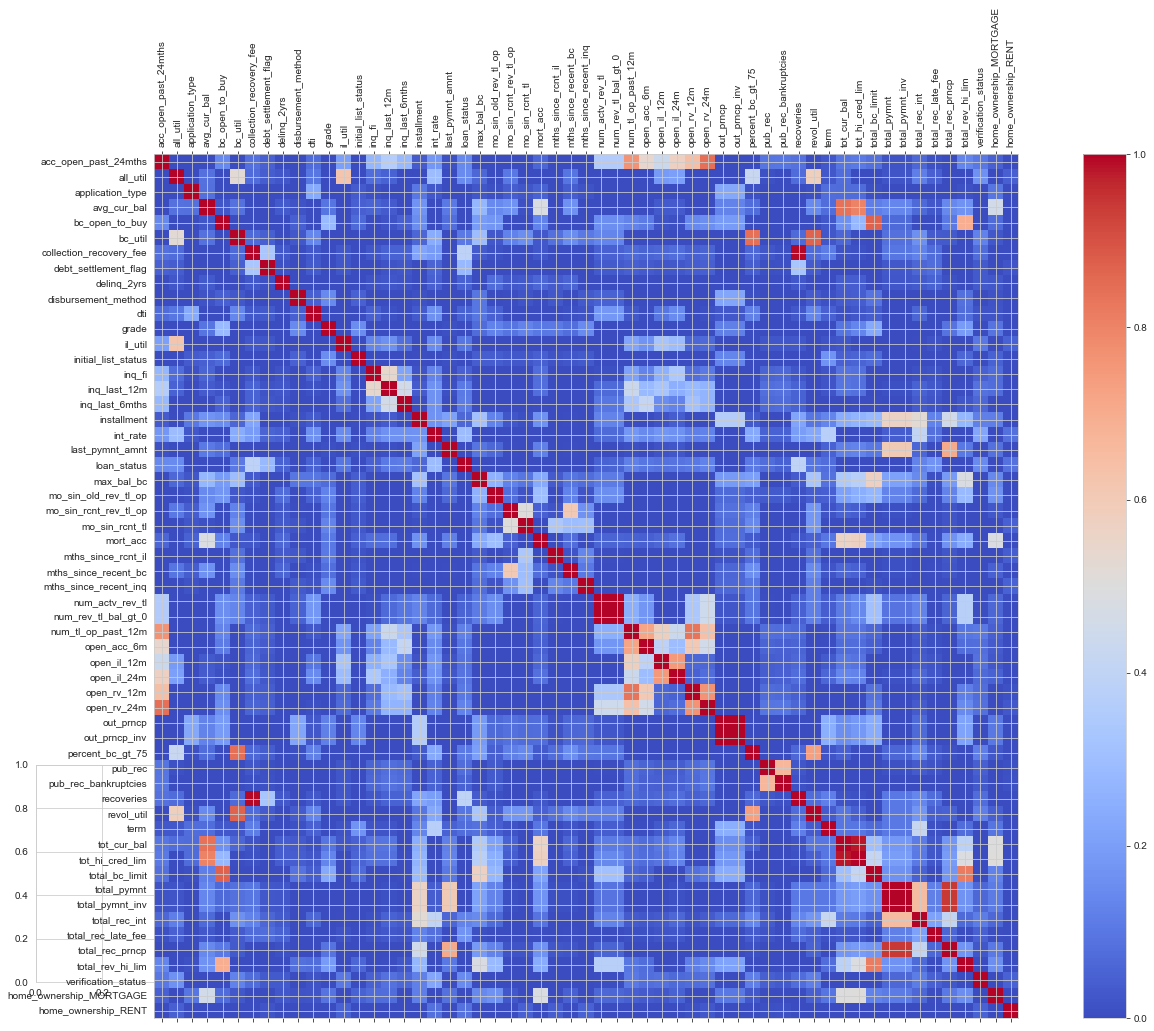

In [28]:
correlations = corrsampledf.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
ax = fig.add_axes([0,0,3,3])
cax = ax.matshow(correlations,cmap='coolwarm', vmin=0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(correlations.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corrsampledf.columns)
ax.set_yticklabels(corrsampledf.columns)
plt.show()

As one can see from the heatmap, there are a couple of pairs that are quite strongly correlated with one another. These are:
- recoveries and collection_recovery_fee
- tot_hi_cred_lim and avg_cur_bal
- tot_cur_bal and avg_cur_bal
- total_bc_limit and bc_open_to_buy
- revol_util and bc_util
- percent_bc_gt_75 and bc_util
- total_rec_prncp and total_pymnt
- total_rec_prncp and total_pymnt_inv
- out_prncp and out_prncp_inv
- num_actv_rev_tl and num_actv_rev_0

I will look at the correlations with the dependent variable of the columns in pairs and drop the ones which are less correlated.

In [29]:
to_drop=['collection_recovery_fee', 'avg_cur_bal', 'total_bc_limit', 'bc_util', 'total_pymnt_inv', 'out_prncp_inv', 'num_actv_rev_tl']
corrsample=corrsample.drop(to_drop)
#By calling the function .intersection, I will drop all the columns that I do not wish to use
corrsampledf=sampledf[sampledf.columns.intersection(corrsample.index)]

In [30]:
corrsampledf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140247 entries, 708961 to 717404
Data columns (total 50 columns):
acc_open_past_24mths       140247 non-null float64
all_util                   140247 non-null float64
application_type           140247 non-null int64
bc_open_to_buy             140247 non-null float64
debt_settlement_flag       140247 non-null int64
delinq_2yrs                140247 non-null float64
disbursement_method        140247 non-null int64
dti                        140247 non-null float64
grade                      140247 non-null int64
il_util                    140247 non-null float64
initial_list_status        140247 non-null int64
inq_fi                     140247 non-null float64
inq_last_12m               140247 non-null float64
inq_last_6mths             140247 non-null float64
installment                140247 non-null float64
int_rate                   140247 non-null float64
last_pymnt_amnt            140247 non-null float64
loan_status                

Now, I want to drop the columns from the test set that have been dropped from the training set in the previous steps

In [31]:
test_df = test_df[corrsampledf.columns]

Now, I can mve to training the first model

In [32]:
X_train = corrsampledf.iloc[:,corrsampledf.columns != 'loan_status']
y_train = corrsampledf[['loan_status']]

X_test = test_df.iloc[:,test_df.columns != 'loan_status']
y_test = test_df[['loan_status']]

In [33]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
lr_probs = logmodel.predict_proba(X_test)
LR_predictions = logmodel.predict(X_test)

/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [34]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test,LR_predictions))
print(confusion_matrix(y_test, LR_predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    248528
           1       0.68      0.80      0.73     26714

    accuracy                           0.94    275242
   macro avg       0.83      0.88      0.85    275242
weighted avg       0.95      0.94      0.95    275242

[[238405  10123]
 [  5415  21299]]


Logistic Regression ROC AUC:0.9284054072405726


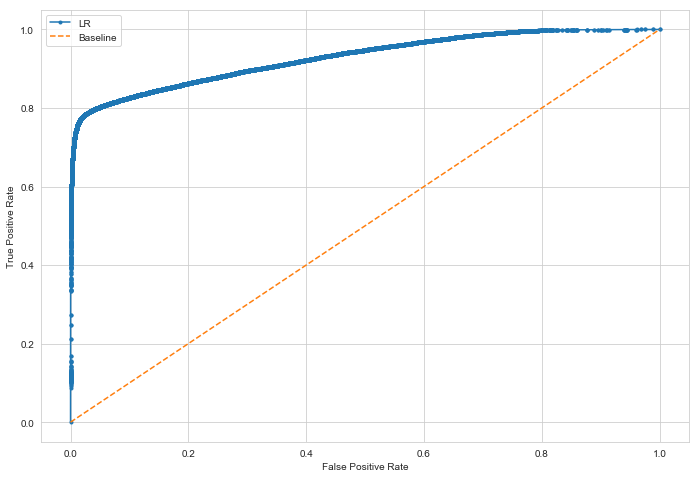

In [35]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, LR_predictions)
#baseline probability
bs_probs = [0 for _ in range(len(y_test))]
#taking only the probabilities for 1s (predict_proba outputs the probability for each class in the label)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
bs_auc = roc_auc_score(y_test, bs_probs)
print("Logistic Regression ROC AUC:{}".format(lr_auc))

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)

#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot(lr_fpr, lr_tpr, marker='.', label='LR') 
plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
#adding x- and y-axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#show legend
plt.legend()
# show the plot
plt.show()

Logistic Regression F1 Score:0.7327301499931196


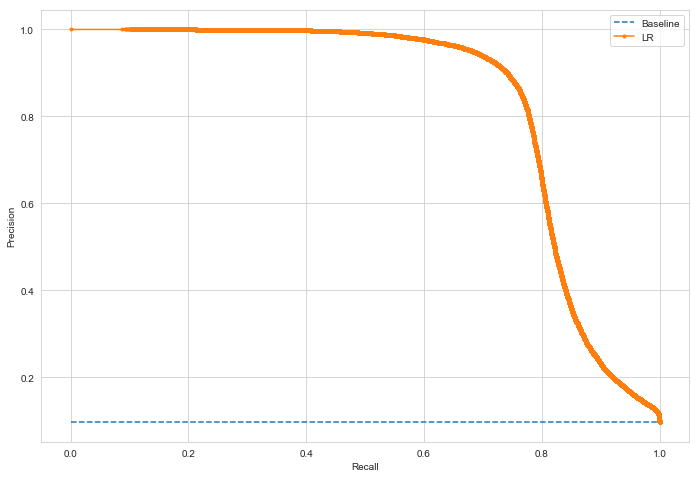

In [36]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, LR_predictions), auc(lr_recall, lr_precision)
print("Logistic Regression F1 Score:{}".format(lr_f1))
baseline = (len(y_test[y_test['loan_status']==1]) / len(y_test))
#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot(lr_recall, lr_precision, marker='.', label='LR')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Now, I will attempt to build a Random Forest. I will use the same variables as in the Logistic Regression since they seemed to have the highest correlation rates and proved to be a quite effective combination of predictors.

In [37]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
rf_probs = rfc.predict_proba(X_test)
RF_predictions = rfc.predict(X_test)

/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
print(classification_report(y_test,RF_predictions))
print(confusion_matrix(y_test,RF_predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248528
           1       0.84      0.85      0.85     26714

    accuracy                           0.97    275242
   macro avg       0.91      0.92      0.91    275242
weighted avg       0.97      0.97      0.97    275242

[[244129   4399]
 [  3884  22830]]


Random Forest ROC AUC:0.9570138440587004


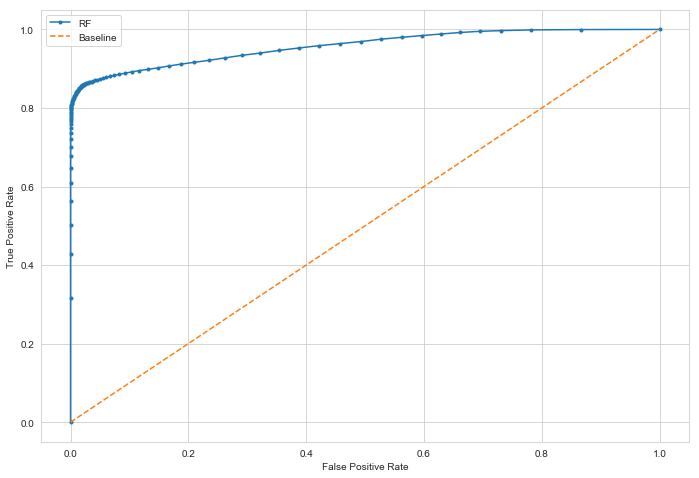

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, RF_predictions)
#baseline probability
bs_probs = [0 for _ in range(len(y_test))]
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
bs_auc = roc_auc_score(y_test, bs_probs)
print("Random Forest ROC AUC:{}".format(rf_auc))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)

#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF') 
plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
#adding x- and y-axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#show legend
plt.legend()
# show the plot
plt.show()

Random Forest F1 Score:0.8464490295311717


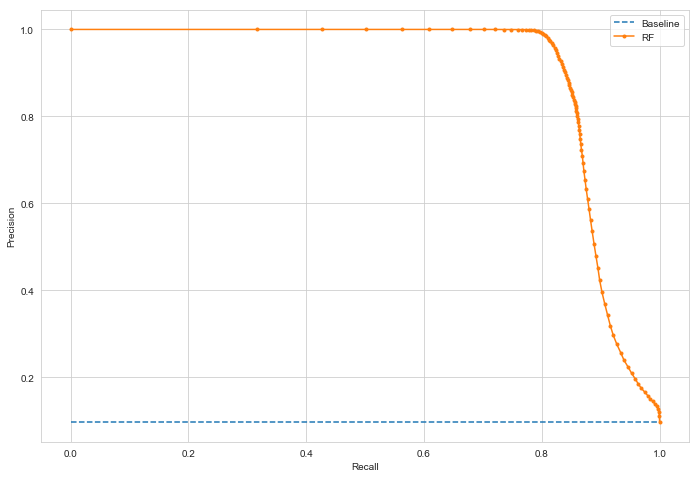

In [40]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_f1, rf_auc = f1_score(y_test, RF_predictions), auc(rf_recall, rf_precision)
print("Random Forest F1 Score:{}".format(rf_f1))
baseline = (len(y_test[y_test['loan_status']==1]) / len(y_test))
#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot(rf_recall, rf_precision, marker='.', label='RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

As one can see, the model has performed slightly better than the Logistic Regression, judging by the ROC AUC. However, the F1 score improvement is significant. Thus, RF becomes the best performing model. Now, I will try to create a new model, using XGBoost.

In [41]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#above two lines were to handle an error that I kept on getting
#Importing necessary libraries
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Turning data into a matrix required by XGBoost
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
#Building a model with chosen parameters (based on research and intuition)
XGB_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.3,
                max_depth = 6, alpha = 10, n_estimators = 20, eval_metric='auc')

XGB_model.fit(X_train,y_train)
xgb_probs = XGB_model.predict_proba(X_test)
XGB_preds = XGB_model.predict(X_test)

/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Random Forest ROC AUC:0.9597489345709552


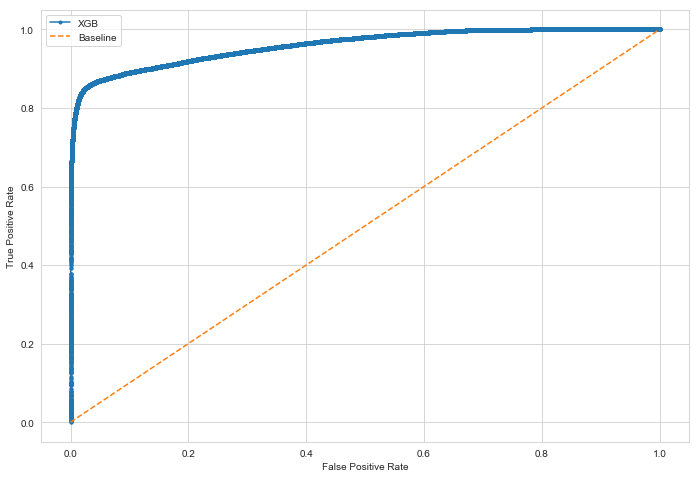

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, XGB_preds)
#baseline probability
bs_probs = [0 for _ in range(len(y_test))]
xgb_probs = xgb_probs[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
bs_auc = roc_auc_score(y_test, bs_probs)
print("Random Forest ROC AUC:{}".format(xgb_auc))

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)

#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB') 
plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
#adding x- and y-axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#show legend
plt.legend()
# show the plot
plt.show()

In [43]:
print(classification_report(y_test,XGB_preds))
print(confusion_matrix(y_test,XGB_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248528
           1       0.79      0.85      0.82     26714

    accuracy                           0.96    275242
   macro avg       0.89      0.91      0.90    275242
weighted avg       0.97      0.96      0.96    275242

[[242684   5844]
 [  4083  22631]]


XGB F1 Score:0.8201271992607223


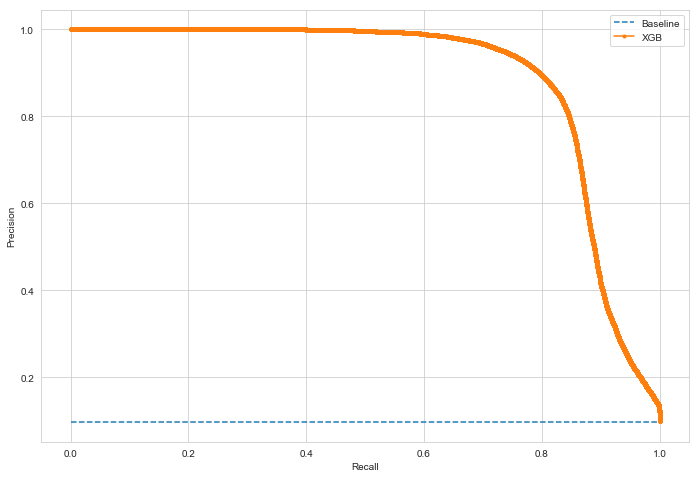

In [44]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test, XGB_preds), auc(xgb_recall, xgb_precision)
print("XGB F1 Score:{}".format(xgb_f1))
baseline = (len(y_test[y_test['loan_status']==1]) / len(y_test))
#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

The XGBoost model has performed very well on the data. With the default parameters, it delivered ~.96 AUC, becoming the new best performing algorithm by the ROC AUC metric, before Logistic Regression and Random Forest. One advantage the XGBoost model might have over the remaining 2 algorithms is that it is parallelizable, making it more feasible for huge datasets and more time efficient, and has multiple parameters that can be tuned, hence delivering bigger flexibility to the dataset. However, XGB's F1 score is worse by 2 percentage points than that of the Random Forest. 

At this point, I will choose which algorithm to further perform hyperparameter tuning on. The choice is between Random Forest which had a better F1 score and XGBoost, which had a higher ROC AUC. To choose which model is better in this case, one should look at the distribution of the dependent variable. We have a rather unbalanced dataset. In such instances, ROC AUC might not be the best metric to decide the model performance on. It would be better to look at the confisuion matrix, analyze its False Positive and False Negative rates, and choose the model which corresponds with the business needs better. In case of this project, I am more concerned about having a lot of Type II errors, while I'm ready to accept some Type I ones. It is because not detecting a client who will default (Type II error i.e. False Negative) can be more detrimental to the business than identifying a reliable client as a potential defaulter and rejecting their loan application. In fact, Random Forest has less False Negatives (3884) than XGB (4083), leading me to favor RF. Furthermore, we can use F1 metric. F1 score takes the tradeoff between minimizing FPR and FNR into account and can be a more reliable metric than simple ROC AUC. Judging by this metric, Random Forest is also a better performer. Thus, I will decide to use Random Forest as the final algorithm, and will attempt hyperparameter tuning to find the best combination of parameters. It is, however, worth acknowledging that tuning other algorithms could've delivered better results. Further steps could include trying to train the models (at least the top performing 3) on more (or less - but unlikely to get better results) features.

In [49]:
#I will use a random grid search because of the computational power constraints
from sklearn.model_selection import RandomizedSearchCV
#constructing a parameters grid
param_grid = {'n_estimators':[50, 100, 200, 500],
             'max_depth':[None, 10, 25, 50],
             'min_samples_split':[2, 5, 10, 30]
             }
rfc = RandomForestClassifier(oob_score=True)
RF_rand = RandomizedSearchCV(estimator = rfc, 
                            param_distributions = param_grid,
                            cv = 5, 
                            scoring = 'f1', 
                            verbose=1, 
                            n_jobs = -1)
RF_rand.fit(X_train, y_train)

print(RF_rand.best_params_)
print("Best oob score: {}".format(RF_rand.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.9min finished
/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best oob score: 0.9401679791931606


In [51]:
#Training the final model with the best parameters
final_rfc = RandomForestClassifier(n_estimators=200, min_samples_split=10, max_depth=None)
final_rfc.fit(X_train,y_train)
rf_probs = final_rfc.predict_proba(X_test)
RF_predictions = final_rfc.predict(X_test)
print(classification_report(y_test,RF_predictions))
print(confusion_matrix(y_test,RF_predictions))

/Users/kubawarmuz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248528
           1       0.84      0.86      0.85     26714

    accuracy                           0.97    275242
   macro avg       0.91      0.92      0.91    275242
weighted avg       0.97      0.97      0.97    275242

[[244013   4515]
 [  3862  22852]]


Random Forest ROC AUC:0.9580447347863084


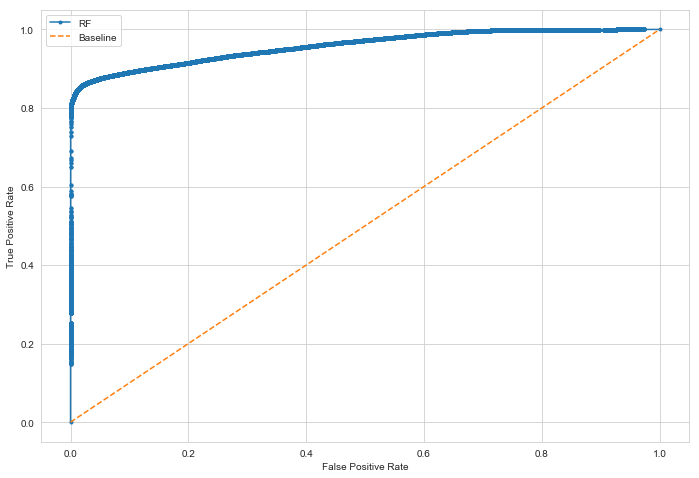

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, RF_predictions)
#baseline probability
bs_probs = [0 for _ in range(len(y_test))]
rf_probs = rf_probs[:, 1]
rf_auc = roc_auc_score(y_test, rf_probs)
bs_auc = roc_auc_score(y_test, bs_probs)
print("Random Forest ROC AUC:{}".format(rf_auc))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)

#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF') 
plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
#adding x- and y-axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#show legend
plt.legend()
# show the plot
plt.show()

Random Forest F1 Score:0.8451027162959264


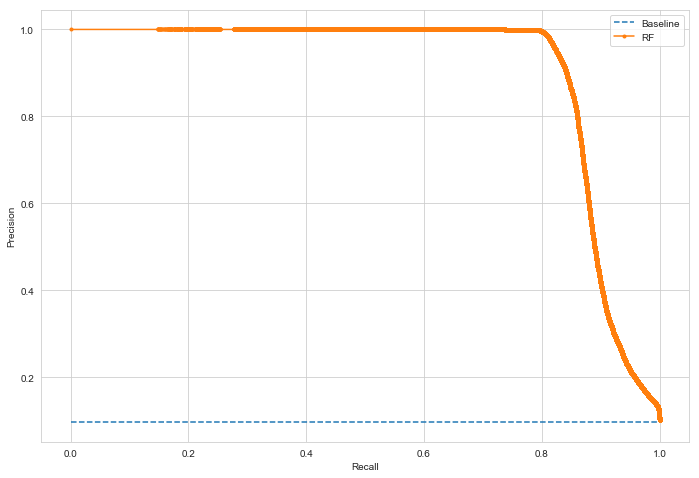

In [53]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_f1, rf_auc = f1_score(y_test, RF_predictions), auc(rf_recall, rf_precision)
print("Random Forest F1 Score:{}".format(rf_f1))
baseline = (len(y_test[y_test['loan_status']==1]) / len(y_test))
#Plotting the curve
fig = plt.figure() #defining a figure
ax = fig.add_axes([0,0,1.5,1.5]) #setting axes
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot(rf_recall, rf_precision, marker='.', label='RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

The performance of the algorithm didn't improve significantly after hyperparameter tuning, although the number of True Positives has increased, and at the end, this is what one cares about the most. As it is now, the model could provide a lot of business benefits, however, before the deployment on production, it would need some refinement (e.g. trying the model with different set of features, e.g. by including more categrical variables).

# Conclusions
The client that I am working for has had 12.6% of loans running on default. After the entire process of data processing, I obtained a model that was accurate in judging whether or not the loan will get defaulted in 95%. The recall metric, which tells us what percentage of positives the model labeled as such (what fraction of defaults were predicted to be defaults) is 0.86. It means that implementing this model in the lending platform that I work for and basing all decisions of whether or not the loan should be issued on this model, the client could 86% of bad loans that have been issued. I believe that it is a promising solution, which is worth pursuing. It is possible that with more thorough development of the algorithm, I could obtain even higher recall, for example around 90-95%. On the other hand, it is worth acknowledging that in a real-life business context this model should not be the final judge of whether or not a loan should be issued. I can imagine a case in which a High Net Worth Individual wanted a loan from the client, but for some reason the algorithm would evaluate this client to be likely to run on default. Such situation should then be considered by a human having actual experience with working with clients. It is because rejecting a HNWI could have further repercussions, such as for example damaged reputation driving other HNWIs away from the loan issuer. 

As mentioned before, there is always a room for improvement. In this case, I could include more features in the model, try an entirely new one, or use a promising XGBoost with different parameters. 